In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [2]:
df=pd.read_csv('learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=0)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [3]:
class DNN_1(nn.Module):
    def __init__(self, input_dim, dropout):
        super(DNN_1, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.bn1 = nn.BatchNorm1d(32)
        self.layer2 = nn.Linear(32, 16)
        self.bn2 = nn.BatchNorm1d(16)
        self.layer3 = nn.Linear(16, 8)
        self.bn3 = nn.BatchNorm1d(8)
        self.layer4 = nn.Linear(8, 4)
        self.bn4 = nn.BatchNorm1d(4)
        self.output_layer = nn.Linear(4, 1)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))  
        x = self.dropout(x)
        
        x = torch.relu(self.bn2(self.layer2(x)))  
        x = self.dropout(x)

        x = torch.relu(self.bn3(self.layer3(x)))  
        x = self.dropout(x)

        x = torch.relu(self.bn4(self.layer4(x))) 
        x = self.dropout(x)

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [4]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

Optunaの設定

In [5]:
def objective(trial):
    # ハイパーパラメータのサンプリング
    dropout= trial.suggest_float("dropout", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   

    # モデルの定義
    model = DNN_1(
        input_dim=X_train_tensor.shape[1],
        dropout=dropout
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs >=0.5).float()
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stoppingの判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaのプルーニング機能
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  


最適化

In [6]:
device_id = 0  
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-18 13:38:48,763] A new study created in memory with name: no-name-9587a9e8-a9ff-46c9-ab38-f82759cbf222
/tmp/ipykernel_41708/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41708/1443040819.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:38:54,658] Trial 0 finished with value: 0.0 and parameters: {'dropout': 0.35000000000000003, 'learning_rate': 0.014885829544289764, 'weight_decay': 0.00015038839157415643}. Best is trial 0 with value: 0.0.


Early stopping at epoch 29
Final MCC: 0.0000


/tmp/ipykernel_41708/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41708/1443040819.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:39:00,787] Trial 1 finished with value: 0.0 and parameters: {'dropout': 0.45, 'learning_rate': 0.0009302498820185496, 'weight_decay': 0.06949430132922509}. Best is trial 0 with value: 0.0.


Early stopping at epoch 42
Final MCC: 0.0000


/tmp/ipykernel_41708/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41708/1443040819.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:39:04,010] Trial 2 finished with value: 0.0 and parameters: {'dropout': 0.15000000000000002, 'learning_rate': 0.003473958546321181, 'weight_decay': 0.018865069254551926}. Best is trial 0 with value: 0.0.


Early stopping at epoch 32
Final MCC: 0.0000


/tmp/ipykernel_41708/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41708/1443040819.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:39:07,680] Trial 3 finished with value: 0.0 and parameters: {'dropout': 0.45, 'learning_rate': 0.005899980834128264, 'weight_decay': 0.0001895113000700072}. Best is trial 0 with value: 0.0.


Early stopping at epoch 29
Final MCC: 0.0000


/tmp/ipykernel_41708/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41708/1443040819.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:39:10,382] Trial 4 finished with value: 0.0 and parameters: {'dropout': 0.05, 'learning_rate': 0.017242493816331965, 'weight_decay': 0.0030552995949499266}. Best is trial 0 with value: 0.0.
/tmp/ipykernel_41708/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com

Early stopping at epoch 21
Final MCC: 0.0000


[I 2024-12-18 13:39:22,410] Trial 6 finished with value: 0.0 and parameters: {'dropout': 0.4, 'learning_rate': 0.0004170466707387757, 'weight_decay': 0.03374928520567246}. Best is trial 0 with value: 0.0.
/tmp/ipykernel_41708/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41708/1443040819.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:39:22,550] Trial 7 pruned. 


Early stopping at epoch 78
Final MCC: 0.0000


[I 2024-12-18 13:39:31,473] Trial 8 finished with value: -0.029793606892833856 and parameters: {'dropout': 0.35000000000000003, 'learning_rate': 0.001060363631790908, 'weight_decay': 1.480408508472105e-05}. Best is trial 0 with value: 0.0.


Early stopping at epoch 65
Final MCC: -0.0298


/tmp/ipykernel_41708/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41708/1443040819.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:39:45,530] Trial 9 finished with value: 0.11323212301422023 and parameters: {'dropout': 0.2, 'learning_rate': 0.0001607914260672055, 'weight_decay': 0.0034228451588922994}. Best is trial 9 with value: 0.11323212301422023.


Final MCC: 0.1132


/tmp/ipykernel_41708/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41708/1443040819.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:39:59,136] Trial 10 finished with value: 0.058815833969955704 and parameters: {'dropout': 0.2, 'learning_rate': 0.00014544443463882227, 'weight_decay': 0.0037316337970716685}. Best is trial 9 with value: 0.11323212301422023.
/tmp/ipykernel_41708/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be remove

Final MCC: 0.0588


[I 2024-12-18 13:39:59,407] Trial 12 pruned. 
[I 2024-12-18 13:40:12,601] Trial 13 finished with value: 0.050483098099700675 and parameters: {'dropout': 0.25, 'learning_rate': 0.0003732312542652582, 'weight_decay': 0.0005456363707385707}. Best is trial 9 with value: 0.11323212301422023.


Final MCC: 0.0505


/tmp/ipykernel_41708/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41708/1443040819.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:40:19,229] Trial 14 finished with value: 0.2163264045918301 and parameters: {'dropout': 0.0, 'learning_rate': 0.00028359708273401724, 'weight_decay': 0.007746506360860651}. Best is trial 14 with value: 0.2163264045918301.
/tmp/ipykernel_41708/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

Early stopping at epoch 52
Final MCC: 0.2163


[I 2024-12-18 13:40:19,522] Trial 16 pruned. 
[I 2024-12-18 13:40:19,677] Trial 17 pruned. 
[I 2024-12-18 13:40:19,833] Trial 18 pruned. 
[I 2024-12-18 13:40:19,996] Trial 19 pruned. 
[I 2024-12-18 13:40:33,685] Trial 20 finished with value: 0.11229042229326915 and parameters: {'dropout': 0.05, 'learning_rate': 0.00024361913360319468, 'weight_decay': 2.998402855381855e-05}. Best is trial 14 with value: 0.2163264045918301.


Early stopping at epoch 98
Final MCC: 0.1123


/tmp/ipykernel_41708/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41708/1443040819.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:40:46,841] Trial 21 finished with value: 0.24224130867330518 and parameters: {'dropout': 0.05, 'learning_rate': 0.0002024593647306743, 'weight_decay': 3.177205265428517e-05}. Best is trial 21 with value: 0.24224130867330518.
/tmp/ipykernel_41708/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be remove

Final MCC: 0.2422


[I 2024-12-18 13:40:47,172] Trial 23 pruned. 
[I 2024-12-18 13:40:47,321] Trial 24 pruned. 
[I 2024-12-18 13:40:47,465] Trial 25 pruned. 
[I 2024-12-18 13:40:57,087] Trial 26 finished with value: 0.2999771510906397 and parameters: {'dropout': 0.15000000000000002, 'learning_rate': 0.0006216112888575313, 'weight_decay': 0.0012950060178640221}. Best is trial 26 with value: 0.2999771510906397.
/tmp/ipykernel_41708/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41708/1443040819.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight

Early stopping at epoch 69
Final MCC: 0.3000


[I 2024-12-18 13:40:57,400] Trial 28 pruned. 
[I 2024-12-18 13:40:57,577] Trial 29 pruned. 
[I 2024-12-18 13:40:57,750] Trial 30 pruned. 
[I 2024-12-18 13:40:57,905] Trial 31 pruned. 
[I 2024-12-18 13:40:58,065] Trial 32 pruned. 
[I 2024-12-18 13:41:10,202] Trial 33 finished with value: 0.13010092165223883 and parameters: {'dropout': 0.05, 'learning_rate': 0.00026427362214399494, 'weight_decay': 0.0024430669170023636}. Best is trial 26 with value: 0.2999771510906397.
/tmp/ipykernel_41708/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41708/1443040819.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_

Early stopping at epoch 90
Final MCC: 0.1301


[I 2024-12-18 13:41:10,513] Trial 35 pruned. 
[I 2024-12-18 13:41:10,688] Trial 36 pruned. 
[I 2024-12-18 13:41:10,834] Trial 37 pruned. 
[I 2024-12-18 13:41:10,992] Trial 38 pruned. 
[I 2024-12-18 13:41:11,152] Trial 39 pruned. 
[I 2024-12-18 13:41:11,299] Trial 40 pruned. 
[I 2024-12-18 13:41:11,467] Trial 41 pruned. 
[I 2024-12-18 13:41:25,005] Trial 42 finished with value: -0.01802491056346171 and parameters: {'dropout': 0.2, 'learning_rate': 0.00015487185505488375, 'weight_decay': 0.0048786402705345}. Best is trial 26 with value: 0.2999771510906397.
/tmp/ipykernel_41708/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41708/1443040819.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be 

Final MCC: -0.0180


[I 2024-12-18 13:41:25,335] Trial 44 pruned. 
[I 2024-12-18 13:41:25,492] Trial 45 pruned. 
[I 2024-12-18 13:41:25,641] Trial 46 pruned. 
[I 2024-12-18 13:41:25,789] Trial 47 pruned. 
[I 2024-12-18 13:41:25,935] Trial 48 pruned. 
[I 2024-12-18 13:41:26,095] Trial 49 pruned. 
[I 2024-12-18 13:41:26,253] Trial 50 pruned. 
[I 2024-12-18 13:41:26,409] Trial 51 pruned. 
[I 2024-12-18 13:41:26,566] Trial 52 pruned. 
[I 2024-12-18 13:41:26,729] Trial 53 pruned. 
[I 2024-12-18 13:41:26,894] Trial 54 pruned. 
[I 2024-12-18 13:41:27,028] Trial 55 pruned. 
[I 2024-12-18 13:41:32,452] Trial 56 finished with value: 0.2283332846729748 and parameters: {'dropout': 0.0, 'learning_rate': 0.00021842637004431154, 'weight_decay': 1.696462670192025e-05}. Best is trial 26 with value: 0.2999771510906397.


Early stopping at epoch 43
Final MCC: 0.2283


/tmp/ipykernel_41708/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41708/1443040819.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:41:33,941] Trial 57 finished with value: 0.0 and parameters: {'dropout': 0.0, 'learning_rate': 0.00012440323226867663, 'weight_decay': 1.9583216372809015e-05}. Best is trial 26 with value: 0.2999771510906397.
/tmp/ipykernel_41708/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See

Early stopping at epoch 10
Final MCC: 0.0000


[I 2024-12-18 13:41:34,264] Trial 59 pruned. 
[I 2024-12-18 13:41:47,968] Trial 60 finished with value: 0.14054807707650874 and parameters: {'dropout': 0.25, 'learning_rate': 0.00010357313001749534, 'weight_decay': 0.000439417860662994}. Best is trial 26 with value: 0.2999771510906397.
/tmp/ipykernel_41708/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41708/1443040819.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:41:48,119] Trial 61 pruned. 


Final MCC: 0.1405


[I 2024-12-18 13:42:01,303] Trial 62 finished with value: 0.1529969212004841 and parameters: {'dropout': 0.25, 'learning_rate': 0.00017982131454714033, 'weight_decay': 0.00020584952752223938}. Best is trial 26 with value: 0.2999771510906397.
/tmp/ipykernel_41708/1443040819.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_41708/1443040819.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:42:01,454] Trial 63 pruned. 


Final MCC: 0.1530


[I 2024-12-18 13:42:01,609] Trial 64 pruned. 
[I 2024-12-18 13:42:01,773] Trial 65 pruned. 
[I 2024-12-18 13:42:01,914] Trial 66 pruned. 
[I 2024-12-18 13:42:02,067] Trial 67 pruned. 
[I 2024-12-18 13:42:02,206] Trial 68 pruned. 
[I 2024-12-18 13:42:02,320] Trial 69 pruned. 
[I 2024-12-18 13:42:02,466] Trial 70 pruned. 
[I 2024-12-18 13:42:02,639] Trial 71 pruned. 
[I 2024-12-18 13:42:02,813] Trial 72 pruned. 
[I 2024-12-18 13:42:02,982] Trial 73 pruned. 
[I 2024-12-18 13:42:03,136] Trial 74 pruned. 
[I 2024-12-18 13:42:03,286] Trial 75 pruned. 
[I 2024-12-18 13:42:03,456] Trial 76 pruned. 
[I 2024-12-18 13:42:03,628] Trial 77 pruned. 
[I 2024-12-18 13:42:03,788] Trial 78 pruned. 
[I 2024-12-18 13:42:17,321] Trial 79 finished with value: 0.18331713208391512 and parameters: {'dropout': 0.05, 'learning_rate': 0.0001956771554684564, 'weight_decay': 0.004470460585629905}. Best is trial 26 with value: 0.2999771510906397.
/tmp/ipykernel_41708/1443040819.py:4: FutureWarning: suggest_logunifor

Final MCC: 0.1833


[I 2024-12-18 13:42:17,623] Trial 81 pruned. 
[I 2024-12-18 13:42:17,787] Trial 82 pruned. 
[I 2024-12-18 13:42:17,955] Trial 83 pruned. 
[I 2024-12-18 13:42:18,113] Trial 84 pruned. 
[I 2024-12-18 13:42:18,307] Trial 85 pruned. 
[I 2024-12-18 13:42:18,449] Trial 86 pruned. 
[I 2024-12-18 13:42:18,608] Trial 87 pruned. 
[I 2024-12-18 13:42:18,782] Trial 88 pruned. 
[I 2024-12-18 13:42:18,941] Trial 89 pruned. 
[I 2024-12-18 13:42:19,107] Trial 90 pruned. 
[I 2024-12-18 13:42:19,266] Trial 91 pruned. 
[I 2024-12-18 13:42:19,433] Trial 92 pruned. 
[I 2024-12-18 13:42:19,590] Trial 93 pruned. 
[I 2024-12-18 13:42:19,758] Trial 94 pruned. 
[I 2024-12-18 13:42:19,913] Trial 95 pruned. 
[I 2024-12-18 13:42:20,071] Trial 96 pruned. 
[I 2024-12-18 13:42:20,227] Trial 97 pruned. 
[I 2024-12-18 13:42:20,398] Trial 98 pruned. 
[I 2024-12-18 13:42:32,510] Trial 99 finished with value: 0.03625054651998926 and parameters: {'dropout': 0.1, 'learning_rate': 0.00031556039779079823, 'weight_decay': 0.00

Final MCC: 0.0363
Best Parameters:  {'dropout': 0.15000000000000002, 'learning_rate': 0.0006216112888575313, 'weight_decay': 0.0012950060178640221}
Best Validation F1:  0.2999771510906397


In [7]:
best_params = study.best_params

# JSON形式で保存
with open("optim_param/optim_DNN_1_params.json", "w") as f:
    json.dump(best_params, f)

print("Best parameters saved to 'best_params.json'")

Best parameters saved to 'best_params.json'


最適化パラメーターで再学習

Epoch [1/100], Loss: 0.6964
Epoch [1/100], Train Loss: 0.6964, Val Loss: 0.6784
Epoch [2/100], Loss: 0.6830
Epoch [2/100], Train Loss: 0.6830, Val Loss: 0.6702
Epoch [3/100], Loss: 0.6783
Epoch [3/100], Train Loss: 0.6783, Val Loss: 0.6609
Epoch [4/100], Loss: 0.6695
Epoch [4/100], Train Loss: 0.6695, Val Loss: 0.6537
Epoch [5/100], Loss: 0.6603
Epoch [5/100], Train Loss: 0.6603, Val Loss: 0.6478
Epoch [6/100], Loss: 0.6529
Epoch [6/100], Train Loss: 0.6529, Val Loss: 0.6418
Epoch [7/100], Loss: 0.6484
Epoch [7/100], Train Loss: 0.6484, Val Loss: 0.6371
Epoch [8/100], Loss: 0.6475
Epoch [8/100], Train Loss: 0.6475, Val Loss: 0.6315
Epoch [9/100], Loss: 0.6355
Epoch [9/100], Train Loss: 0.6355, Val Loss: 0.6272
Epoch [10/100], Loss: 0.6317
Epoch [10/100], Train Loss: 0.6317, Val Loss: 0.6220
Epoch [11/100], Loss: 0.6310
Epoch [11/100], Train Loss: 0.6310, Val Loss: 0.6162
Epoch [12/100], Loss: 0.6280
Epoch [12/100], Train Loss: 0.6280, Val Loss: 0.6101
Epoch [13/100], Loss: 0.6161
Epoch

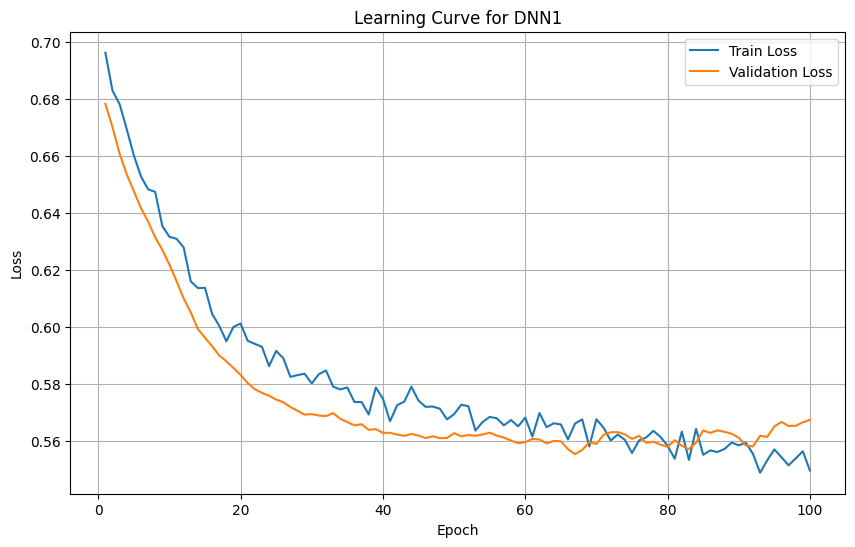

In [12]:
best_params=study.best_params
model = DNN_1(input_dim=X_train_tensor.shape[1],dropout=best_params["dropout"]).to(device)

# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=100
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val.squeeze())
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN1')
plt.legend()
plt.grid()
plt.show()

Accuracy: 62.53%
Precision: 0.4962
Recall: 0.4037
F1 Score: 0.4452
Matthews Correlation Coefficient: 0.1688
Specificity: 0.7568


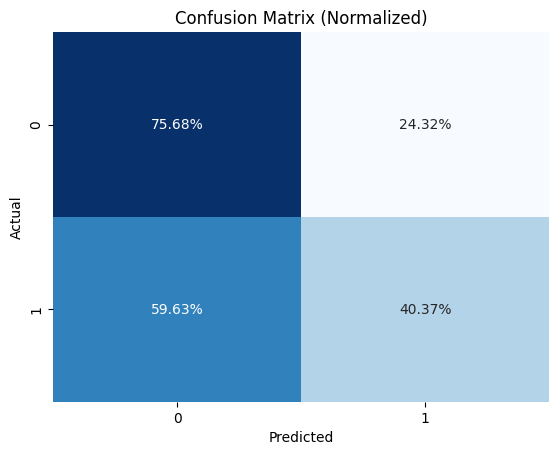

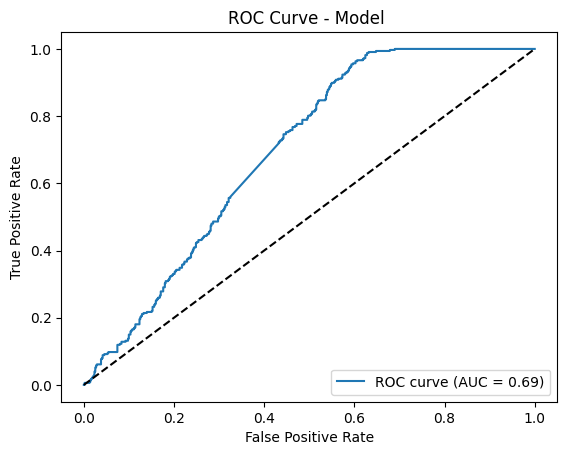

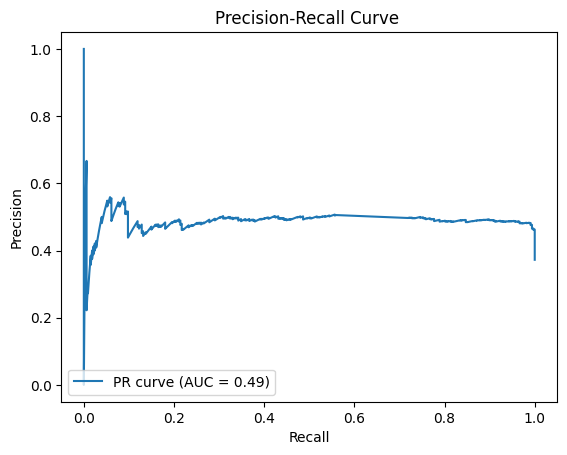

In [13]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >=0.5).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [14]:
# モデルと構造を保存
torch.save(model.state_dict(), 'model_params/DNN_1.pth')


In [11]:
from torchsummary import summary
summary(model, input_size=(X_train_tensor.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             960
       BatchNorm1d-2                   [-1, 32]              64
           Dropout-3                   [-1, 32]               0
            Linear-4                   [-1, 16]             528
       BatchNorm1d-5                   [-1, 16]              32
           Dropout-6                   [-1, 16]               0
            Linear-7                    [-1, 8]             136
       BatchNorm1d-8                    [-1, 8]              16
           Dropout-9                    [-1, 8]               0
           Linear-10                    [-1, 4]              36
      BatchNorm1d-11                    [-1, 4]               8
          Dropout-12                    [-1, 4]               0
           Linear-13                    [-1, 1]               5
Total params: 1,785
Trainable params: 1